In [1]:
import os
os.chdir('../')
# esse comando é melhor do que sys.path.insert(0, '../') pois permite interagir com arquivos do diretorio acima

In [2]:
import pickle
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 167) # opcional, questão de visualização para debugar caso 1

In [3]:
from pynnystock.FileManager import FileManager
from pynnystock.Ativo import Ativo
from pynnystock.Parameters import Parameters
from pynnystock.StatsGatherer import StatsGatherer
from pynnystock.StratsMaestro import StratsMaestro
from pynnystock.Simulator import Simulator
from pynnystock.BootstrapSimulator import BootstrapSimulator
from pynnystock.OptimizerSimulator import OptimizerSimulator

In [4]:
fm = FileManager()

##### Na primeira vez precisa gerar o pickle de ativo_dia_list.pkl
##### Somente executar esse código se o pickle ativo_dia_list.pkl não tiver sido gerado

In [ ]:
# abre arquivo com freefloats
names_pennystocks = fm.getNames()
names_free_float = fm.getFreeFloatNames()
names = list(set(names_pennystocks) & set(names_free_float))
names.sort()

In [ ]:
# gera ativo_dia_list (adl), que é uma lista com resumo dos dias que vai nos auxiliar a filtrar os dias de interesse
# também vai auxiliar na análise de ativos-dia
adl = []
for n in names[0:10]:
#for n in names:
    print(n)
    try:
        a = Ativo(n, fm[n])
        for intraday in a.intraDays:
            d = {'name': a.name,
                 'date': intraday.date,
                 'freefloat': fm.getFreeFloat(n),
                 'stats': intraday.stats}
            adl.append( d )
    except IndexError:
        print("Ativo sem nenhum dado ou dado inconsistente")

In [ ]:
with open('AtivoDiaList.pkl', 'wb') as filehandle: # w de write e b de binary
    pickle.dump(adl,filehandle)

##### Com o pickle ativo_dia_list.pkl gerado, prosseguir daqui

In [5]:
with open('AtivoDiaList.pkl', 'rb') as filehandle:
    ativo_dia_list = pickle.load(filehandle)

In [6]:
pars = Parameters()

In [7]:
sg = StatsGatherer(pars)

In [8]:
sm = StratsMaestro(pars)

In [9]:
sim = Simulator(fm,ativo_dia_list,pars,sm,sg)

In [10]:
bss = BootstrapSimulator(sg)

In [11]:
os = OptimizerSimulator(sim, bss, sg)

In [12]:
# pars.setFilterParameters(gap_threshold=0.1, F_high_threshold=9)
pars.setFilterParameters(prevol_threshold=15000000)
sim.runFiltering()

In [13]:
# pars.setSimParameters(start_money = 10000,allocation=0.1)
# pars.setAlgoParameters(short_after=0, exit_target=0.4, exit_stop=0.4)
# pars.setAlgoParameters(short_after=0.2)

sim.runSimulation()

#sim.saveTrades('case1_trades.pkl')
# sim.openTrades('case1_trades.pkl')

In [14]:
dfd = sg.filtereddf # DataFrame of filtered ativo-dias
dft = sg.tradesdf # DataFrame of trades
dfes = sg.extrastatsdf # DataFrame of extra statistics

##### Algumas análises da simulação

In [15]:
sg.printSimResults()

prevol_threshold 15000000
open_dolar_threshold 2
gap_threshold 0.2
F_low_threshold 0
F_high_threshold 1

short_after 0.1
exit_target 0.3
exit_stop 0.3

start_money 10000
allocation 0.1
locate_fee 0.02
commission 2

Start Money: $10,000.00
End Money: $12,931.70
Number of Trades: 15
Number of filtered ativo-dias: 22
Max Drawdown: 0.03217176460988469


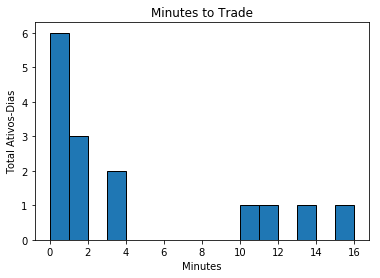

In [16]:
sg.plotHistMinsToTrade()

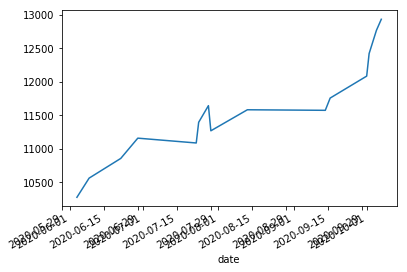

In [17]:
sg.plotEquityCurve()

##### Análise de algumas estratificações

In [18]:
dftr = pd.merge(dft,dfd,how='inner',on=['name','date'])
dftr = dftr[['name','date','gap','factorF','profit','cum_profit']]
dftr

,name,date,gap,factorF,profit,cum_profit
0,CIDM,2020-06-04,2.343511,1.658049,0.300000,1.030000
1,IZEA,2020-06-09,0.856000,1.051235,0.300000,1.060900
2,SINT,2020-06-22,2.416573,1.794230,0.300000,1.092727
3,BHTG,2020-06-29,1.395210,2.910233,0.300000,1.125509
4,MIST,2020-07-23,1.323353,6.343137,-0.042643,1.120709
5,ABUS,2020-07-24,0.289197,1.868844,0.300000,1.154331
6,KODK,2020-07-28,2.675573,4.115038,0.239120,1.181933
7,KODK,2020-07-29,1.286600,12.788022,-0.300000,1.146475
8,IGC,2020-08-13,0.315488,1.561542,0.300000,1.180869
9,SAVA,2020-09-14,1.153614,5.112078,0.014634,1.182597


In [ ]:
bins = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2]
gap = np.clip( dftr['gap'], bins[0], bins[-1] )
dftr.groupby(pd.cut(gap, bins)).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

In [ ]:
dftr.groupby(dftr['date'].dt.to_period('M')).agg(
    winrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0)/(sum(x>=0) + sum(x<0)) ),
    lossrate=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0)/(sum(x>=0) + sum(x<0)) ),
    mean=pd.NamedAgg(column='profit',aggfunc=lambda x: x.mean()),
    mean_of_pos=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x>=0].mean()),
    mean_of_neg=pd.NamedAgg(column='profit',aggfunc=lambda x: x[x<0].mean()),
    count=pd.NamedAgg(column='profit',aggfunc='count'),
    positives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x>=0) ),
    negatives=pd.NamedAgg(column='profit',aggfunc=lambda x: sum(x<0) )
)

##### Analisando o Dataframe com extra statistics

In [ ]:
# aqui podemos fazer alguma análise, basta fazer inner join de dfes com os outros dataframes dfd, dft
dfes

##### Rodando Bootstrap

In [ ]:
bss.runBootstrap()

In [ ]:
sg.printBootstrapResults()

##### Códigos para rodar combinações de parâmetros e otimizar.

In [ ]:
# oficial que gostaríamos de explorar
os.runSimulationGroup(
    prevol_threshold = [800000],
    exit_target=[0.1, 0.2, 0.3, 0.4], 
    exit_stop=[0.1, 0.2, 0.3, 0.4], 
    short_after=[0, 0.1, 0.2, 0.3],
    gap_threshold=[0, 0.1, 0.2],
    F_high_threshold = [1,2,3,4,5]
)

In [ ]:
# rodar para debugar
os.runSimulationGroup(
    prevol_threshold = [15000000],
    exit_target=[0.2, 0.3], 
    exit_stop=[0.3], 
    short_after=[0, 0.1],
    gap_threshold=[0.1],
    F_high_threshold = [1]
)

In [ ]:
# sg.saveGroupResults('teste1.pkl')
sg.appendGroupResults('teste1.pkl')
# sg.openGroupResults('teste1.pkl')

In [ ]:
sg.groupResults

##### Descrição simulações já rodadas

##### Testes temporários em geral